In [241]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ugradio 
import csv
from scipy.optimize import curve_fit
from ugradio import doppler, nch
from astropy import units as u
from astropy.coordinates import SkyCoord, EarthLocation, ICRS
from astropy.time import Time
import datetime
from scipy.stats import chi2
from scipy.stats import chisquare
lab = EarthLocation(lat = nch.lat*u.deg, lon = nch.lon*u.deg, height = nch.alt*u.m)

In [242]:
data1419_1 = np.loadtxt('cassie_1419_906MHzLO_signalRF_maxSamp', dtype = complex)
data1419_2 = np.loadtxt('cassie_1419_906MHzLO_signalRF_maxSamp2', dtype = complex)

data1420_1 = np.loadtxt('cassie_1420_906MHzLO_signalRF_maxSamp', dtype = complex)
data1420_2 = np.loadtxt('cassie_1420_906MHzLO_signalRF_maxSamp2', dtype = complex)

In [243]:
utcobs = datetime.datetime(2023, 2, 22, 19, 11)
obstime = Time(utcobs, scale ='utc', location = lab)

In [244]:
#calculating ra and dec
coord = SkyCoord(frame = "galactic", l = 120*u.deg, b = 0*u.deg, obstime = obstime)
coord.transform_to(ICRS())

<SkyCoord (ICRS): (ra, dec) in deg
    (6.45083114, 62.72572675)>

## Observed Velocity

-17116.46619332217 m / s
-122766.35126131336


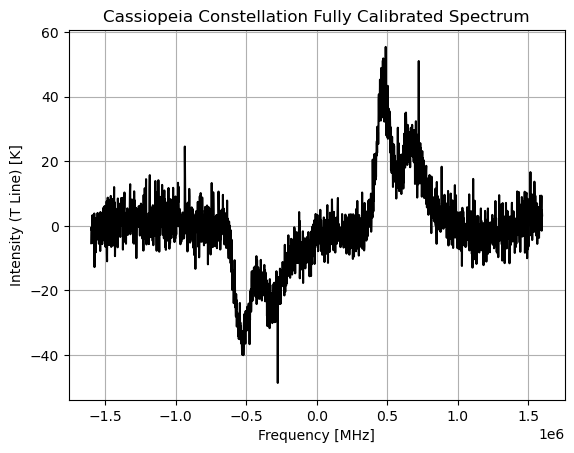

In [321]:
#calculating sline
freqs = np.fft.fftfreq(2048, 1/3.2e6)

poweron = np.mean(np.fft.fftshift(np.abs(np.fft.fft(data1419_1)))**2, axis = 0)
poweroff = np.mean(np.fft.fftshift(np.abs(np.fft.fft(data1420_1 )))**2, axis = 0)

sline = poweron/poweroff

# fig, ax = plt.subplots()
# ax.plot(np.fft.fftshift(freqs), sline ,color ='b')

#calculating Tline
gain = 137.2473291629772

freqs = np.fft.fftfreq(2048, 1/3.2e6)
intensity = sline * gain 
T_line = np.array(intensity) - np.mean(intensity)

fig, ax = plt.subplots()

ax.plot(np.fft.fftshift(freqs), T_line, color = 'black')
ax.set_xlabel('Frequency [MHz]')
ax.set_ylabel('Intensity (T Line) [K]')
ax.set_title('Cassiopeia Constellation Fully Calibrated Spectrum')
plt.grid()
# ax.set_xlim(-0.2e6,1e6)
# plt.savefig("RFspectrum_8.png")

#doppler
freqs = freqs + 1420.906e6
v0 = 1420.405e6 #MHz

delv = freqs - np.array(v0)

# delv = abs(abs(freqs[610])-abs(v0))
# print("delv = ",delv)
doppler = - delv/v0 * 3e8 
# print("doppler = ",doppler)
# print(T_line.size)
T_linecopy = T_line

m,b = np.polyfit(doppler, T_line, 1)
# fig, ax = plt.subplots()
# y= mx+b
# plt.plot(np.fft.fftshift(doppler),np.fft.fftshift(doppler) * m +b  )
# ax.plot(np.fft.fftshift(doppler), np.fft.fftshift(T_line), color = 'black', label ='calculated velocity')

# ax.plot(np.polyfit(np.fft.fftshift(doppler), np.fft.fftshift(T_line), 2))
# plt.show()

#LSR 
a = ugradio.doppler.get_projected_velocity(6.45083114,62.72572675, 2459998.633030077)
print(a)
doppler2 = - np.array(delv/v0) * 3e8 + np.array(a)
print(np.mean(doppler2))
# new = np.array(doppler) +np.array(a)
# ax.plot(np.fft.fftshift(doppler2), np.fft.fftshift(T_line), color ='r', label = 'LSR')
# ax.set_xlabel('Doppler Velocity [m/s]')
# ax.set_ylabel('Intensity (T Line) [K]')
# ax.set_title('Cassiopeia Constellation Fully Calibrated Spectrum')
# ax.legend()
# plt.grid()
# ax.set_xlim(0,200000)
# plt.savefig("LSRvelocity_8.png")
# ax.set_xlim(5000,200000)

In [256]:
T_linecopy = T_line
shiftdoppler2 = np.fft.fftshift(doppler2)
ileft = np.argmin(abs(shiftdoppler2 - 0))
doppler[1727]
print(iright)
print(shiftdoppler2)

1561
[ 215000.43004402  214670.41853322  214340.40702242 ... -459873.10954504
 -460203.12105584 -460533.13256665]


In [257]:
iright = np.argmin(abs(shiftdoppler2 + 300000))
doppler[588]
print(ileft)

651


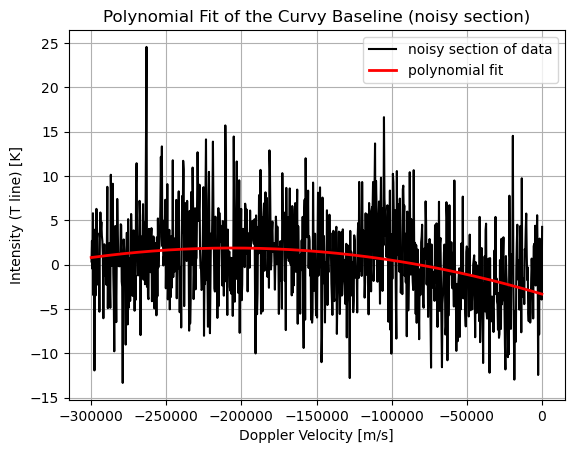

In [281]:
fig, ax = plt.subplots()

ax.plot(shiftdoppler2[ileft:iright], np.fft.fftshift(T_line)[ileft:iright], color ='black', label ='noisy section of data')

#plotting polyfit
polyfit = np.polyfit(shiftdoppler2[ileft:iright], np.fft.fftshift(T_line)[ileft:iright], 2)

#function
p = np.poly1d(polyfit)
#x values
x = np.linspace(-300000, 0, 1000)
#plotting them
ax.plot(x,p(x), color ='r', linewidth = '2', label ='polynomial fit')
ax.set_xlabel('Doppler Velocity [m/s]')
ax.set_ylabel('Intensity (T line) [K]')
ax.set_title('Polynomial Fit of the Curvy Baseline (noisy section)')
ax.legend()
plt.grid()
# plt.savefig("polyfit_8.png")

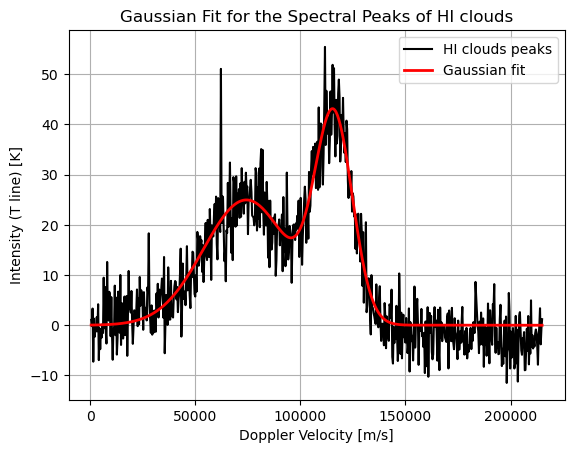

In [295]:
def two_gaussian(x, a1, mean1, sigma1, a2,mean2,sigma2):
   #a is for amplitude
    return a1 * np.exp(-1/2 * ((x - mean1) / sigma1) **2) +  a2 * np.exp(-1/2 * ((x - mean2) / sigma2) **2)

popt, pcov = curve_fit(two_gaussian, shiftdoppler[:ileft], np.fft.fftshift(T_linecopy)[:ileft], p0 = np.array([25,75000,30000,55,123000, 16000]))

plt.plot(shiftdoppler[:ileft], np.fft.fftshift(T_linecopy)[:ileft], color = 'black',label ='HI clouds peaks')
plt.plot(shiftdoppler[:ileft], two_gaussian(shiftdoppler[:ileft], *popt), linewidth = '2',color ='r', label ='Gaussian fit')
plt.xlabel('Doppler Velocity [m/s]')
plt.ylabel('Intensity (T line) [K]')
plt.title('Gaussian Fit for the Spectral Peaks of HI clouds')
plt.legend()
plt.grid()
plt.savefig("gaussian_8.png")
#do [:ileft]


In [240]:
chi, p = chisquare(two_gaussian(shiftdoppler[:ileft], *popt))
print(chi /2048-1)
#bigger than 1, must be less than 1, but the gaussian fit, fits the observation good
#maybe cuz it's noisy


3.823655898877699
